Question : 5

In [1]:
!pip install joblib

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn import linear_model
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, classification_report,recall_score,f1_score,precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from joblib import load,dump

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 160)

In [3]:
seattle = pd.read_csv("seattle_labeled.csv")

# Question : 5

In [4]:
columns= ['id','property_type', 'room_type', 'accommodates','bathrooms', 'bedrooms', 'beds', 'bed_type',
          'amenities', 'price', 'security_deposit', 'cleaning_fee','guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',"Label"]
df = seattle[columns]
df = df.reset_index()
df.head(1)

,index,id,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,Label
0,0,241032,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,365,2


In [5]:
df['amenities'] = df['amenities'].apply(lambda x: x.replace('{','')
                                                              .replace('}','')
                                                              .replace('"','')
                                                              .replace(' ','_')
                                                              .replace(',',' ')
                                                              .split()
                                                             )
amenities_list = list(set(df['amenities'].sum()))
len(amenities_list)

41

In [6]:
temp = []
for i in range(len(df)):
    len(df['amenities'][i])
    temp.append(len(df['amenities'][i]))
df["Total_Ammenities"] = temp
df.drop(columns= "amenities",axis=1,inplace=True)
df.head(1)

,index,id,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,Label,Total_Ammenities
0,0,241032,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,85.0,0.0,0.0,2,5.0,1,365,2,10


# Selecting Relevant Feature to select the Property Type

In [7]:
df1 = df.loc[:,["id",'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'minimum_nights', 'maximum_nights','Total_Ammenities','property_type','Label']]

In [8]:
def uni_count_plot(df,col):
    plt.figure(figsize=(12,5))
    ax=sns.countplot(df[col],linewidth=3,order= df[col].value_counts().index,palette="Spectral")
    for bar in ax.patches:
        h= bar.get_height()
        x= bar.get_x()+bar.get_width()/2
        ax.annotate(h, (x, h), va = "bottom", ha ="center" )
    plt.tight_layout()

    
def crosstab(a): 
    plt.figure(figsize=(12,8))
    pd.crosstab(df1.property_type,a).plot(kind='bar',)
    plt.show()

def heatmap(X):    
    plt.figure(figsize = (10,6))
    sns.heatmap(X.corr(),annot=True,cmap="mako")
    plt.show()    

def cat_or_cont(df):
    cat=[]
    cont=[]
    for col in df.keys():
        if df[col].nunique() >20:
            cont.append(col)
        else:
            cat.append(col)
    return cat
    print(tabulate({"Categorical":cat,"Continuous":cont},headers="keys"))

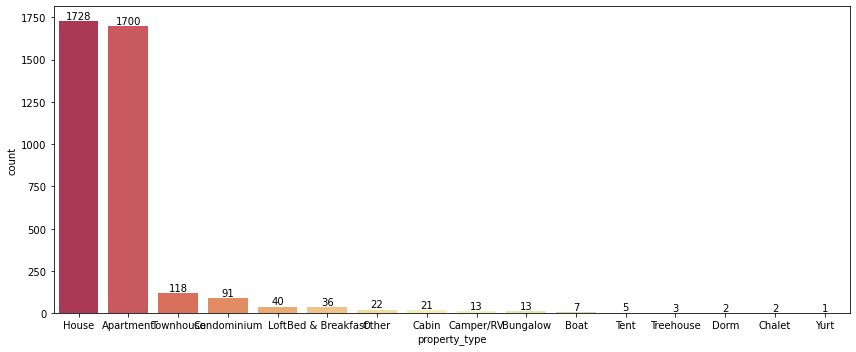

In [9]:
uni_count_plot(df1,"property_type")

* Most common properties are  house and apartment
* Rest all the properties are very scarce in number thus we won't achieve accurate results.
* Thus We'll Consider only those House are Apartment for further Classification.

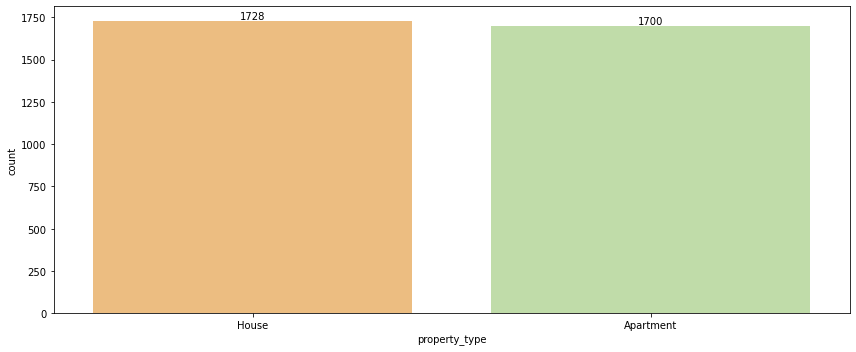

In [10]:
df1 = df1[(df1.property_type == "House")|(df1.property_type == "Apartment")]
uni_count_plot(df1,"property_type")

* Encoding property type into binary variables i.e. 0,1

In [11]:
property_encoder = {"property_type":{"Apartment":0,"House":1}}
df1.replace(property_encoder, inplace=True)

In [12]:
df1.head(2)

,id,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,minimum_nights,maximum_nights,Total_Ammenities,property_type,Label
0,241032,Entire home/apt,4,1.0,1.0,1.0,Real Bed,85.0,0.0,0.0,2,1,365,10,0,2
1,9167786,Private room,2,1.0,1.0,1.0,Real Bed,50.0,0.0,10.0,1,1,1125,14,1,2


<Figure size 864x576 with 0 Axes>

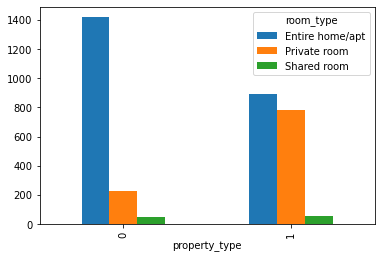

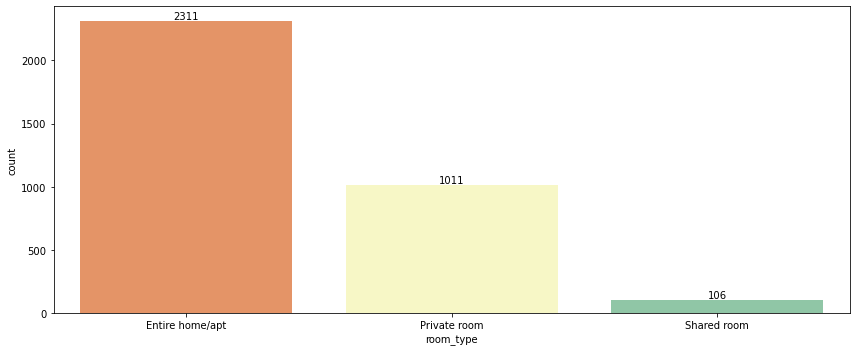

In [13]:
crosstab(df1.room_type)
uni_count_plot(df1,"room_type")

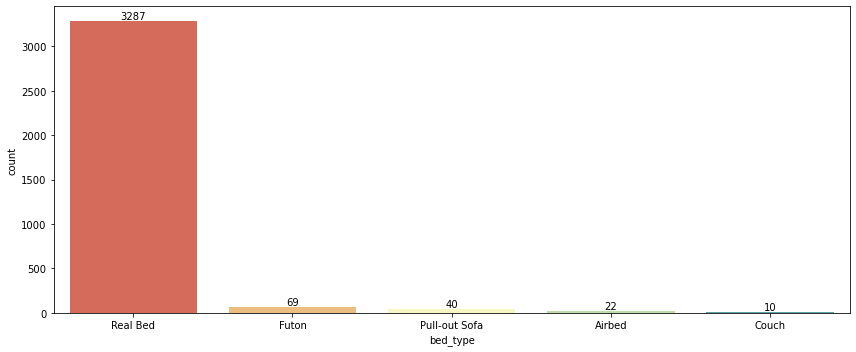

In [14]:
uni_count_plot(df1,"bed_type")

* Mostly the bed_type is Real Bed thus won't affect the Analysis.
* Thus Dropping the feature bed_type

In [15]:
df1.drop("bed_type",axis=1, inplace=True)

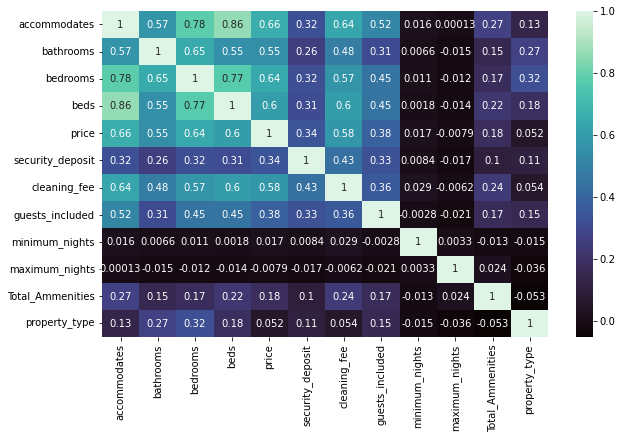

In [16]:
heatmap(df1.drop(["id","room_type","Label"], axis =1))

Feature mentioned below (.05 as threshold) have correlation with Property_Type
*    accomodates
*    bathrooms
*    bedrooms
*   beds
*    security_deposit
*    guests_included 
*    price
*    cleaning_fee
*    Total_Ammenities
    

In [62]:
X =df1[["id","accommodates","bathrooms","bedrooms","beds","security_deposit","guests_included","price","cleaning_fee","Total_Ammenities","room_type","Label"]]

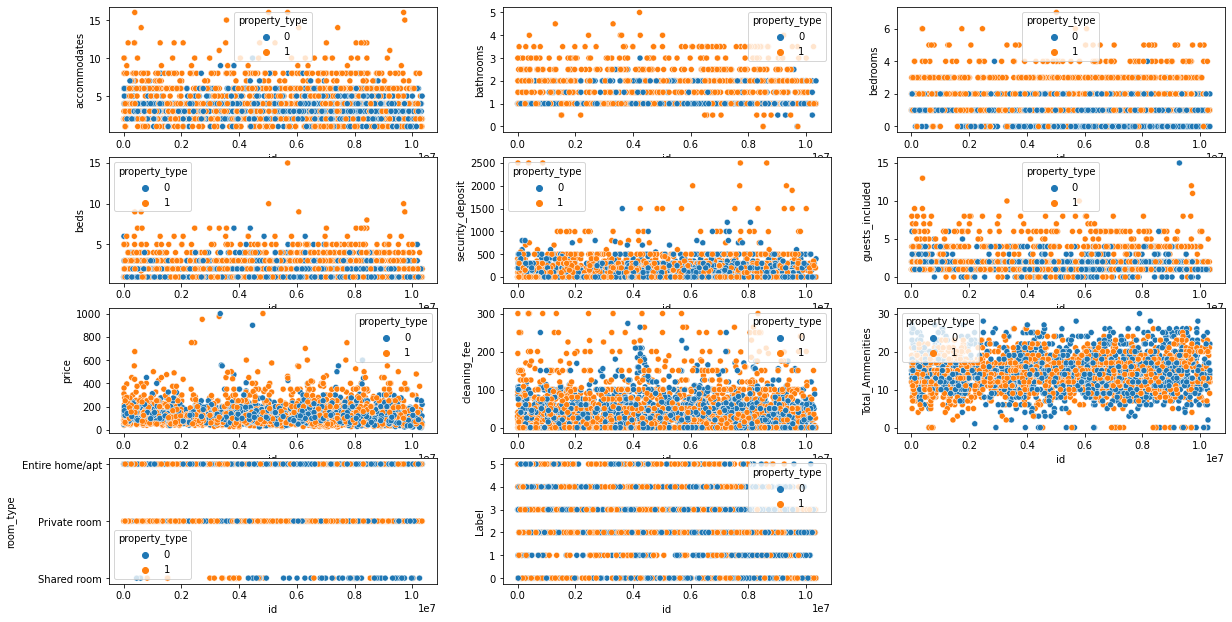

In [20]:
count=1
plt.subplots(figsize=(20, 30))
for i in X.drop("id",axis=1).columns:
    plt.subplot(11,3,count)
    sns.scatterplot(df1["id"],df1[i],hue=df1.property_type)
    count+=1
plt.show()

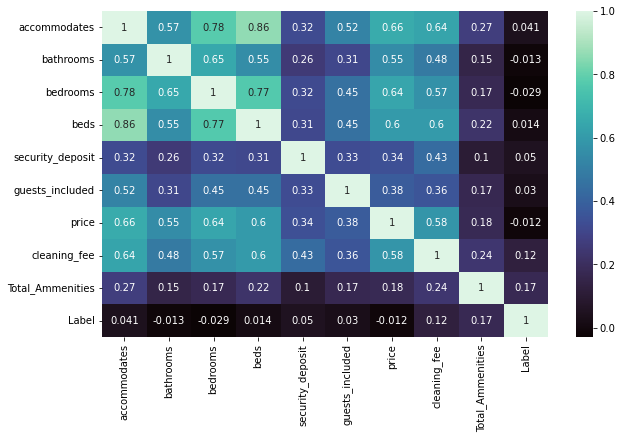

In [21]:
heatmap(X.drop("id",axis=1))

We can observe that there is multi-colinearity between the selected features, thus some feature engineering need to be done with these features

We'll Merge 
* Price and cleaning fee
* Guests_included and Accomodates

In [63]:
X["Total_Cost"]= X.price + X.cleaning_fee
X["Total_Capacity"]= X.accommodates + X.guests_included
X.drop(["price","cleaning_fee","accommodates","guests_included"],axis = 1,inplace=True)

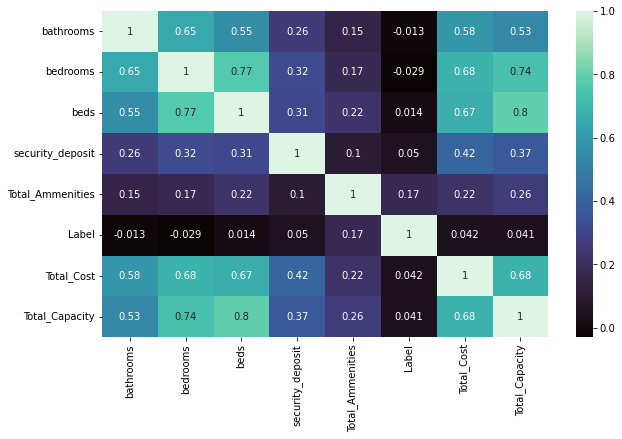

In [34]:
heatmap(X.drop("id", axis=1))

Dropping the columns bed and bedroom

In [64]:
X.drop(["bedrooms","beds"],axis = 1,inplace=True)

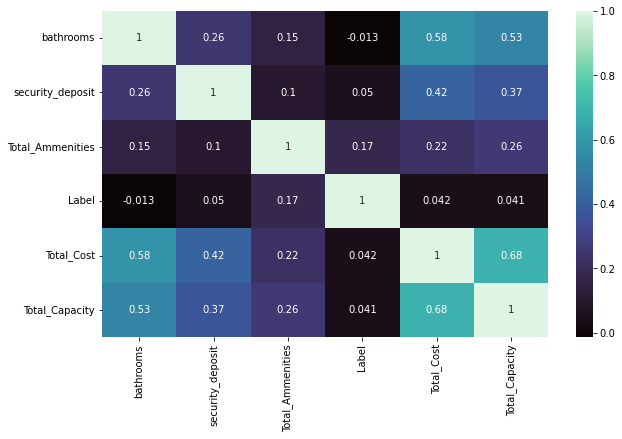

In [28]:
heatmap(X.drop("id",axis=1))

In [65]:
X.head(1)

,id,bathrooms,security_deposit,Total_Ammenities,room_type,Label,Total_Cost,Total_Capacity
0,241032,1.0,0.0,10,Entire home/apt,2,85.0,6


In [66]:
Final_df = X.copy()

In [37]:
X = pd.concat([X.drop("room_type", axis=1), pd.get_dummies(X["room_type"], prefix="room_type", prefix_sep='_', drop_first=True)],axis=1)
X = pd.concat([X.drop("Label", axis=1), pd.get_dummies(X["Label"], prefix="Label", prefix_sep='_', drop_first=True)],axis=1)
X.head(1)

,id,bathrooms,security_deposit,Total_Ammenities,Total_Cost,Total_Capacity,room_type_Private room,room_type_Shared room,Label_1,Label_2,Label_3,Label_4,Label_5
0,241032,1.0,0.0,10,85.0,6,0,0,0,1,0,0,0


array([<AxesSubplot:title={'center':'Total_Cost'}>,
       <AxesSubplot:title={'center':'Total_Capacity'}>,
       <AxesSubplot:title={'center':'room_type_Private room'}>],
      dtype=object)

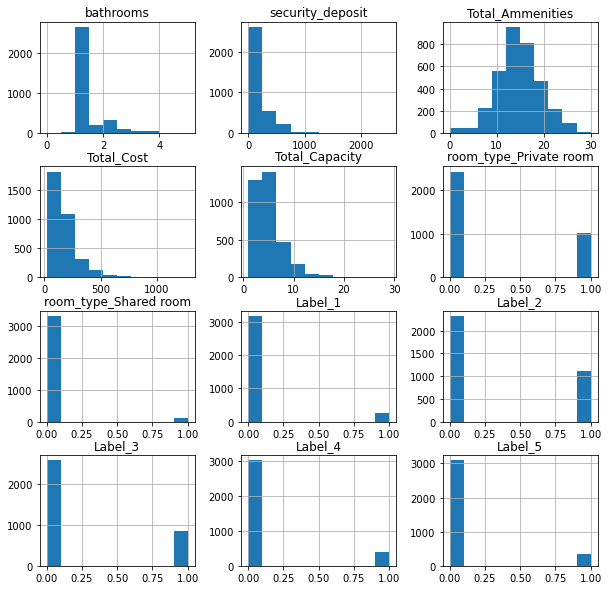

In [217]:
X.drop("id",axis=1).hist(figsize=(10,10),bins=10)[1]

In [38]:
temp = []
for i in X.Total_Cost:
    temp.append(np.log(i))
X.Total_Cost = temp

In [39]:
y = df1["property_type"]
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size = .20,random_state = 101)
X_train = X_train1.drop("id",axis =1)
X_test =  X_test1.drop("id",axis =1)

In [44]:
model_name = []
accuracy_list = []
recall_list = []
precision_list = []
f1_score_list = []
cv_score_list = []

In [43]:
#Creating a function for  checki9ng thge model performance
def model_performance(model):
    # accuracy on X_test
    acc = round(model.score(X_test, y_test)*100,2)
    print(f"The accuracy of {model} is {acc} %\n")
    #creating a confusion matrix
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(accuracy_score(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred)
    cmd = pd.DataFrame(cm)
    cmd.rename(columns={0:"Apartment",1:"Own House",2:"Other"}, 
           index = {0:"Apartment",1:"Own House",2:"Other"},
           inplace = True)
    model_name.append(str(model))
    recall_list.append(recall_score(y_test, y_pred))
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred))
    f1_score_list.append(f1_score(y_test, y_pred))
    cv_score_list.append(np.mean(cross_val_score(model,X_train,y_train,cv=5)))
    
    
    
    
    sns.heatmap(cmd,annot = True,fmt="g")
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()
    return acc , y_pred

The accuracy of LogisticRegression() is 75.36 %

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       332
           1       0.77      0.74      0.76       354

    accuracy                           0.75       686
   macro avg       0.75      0.75      0.75       686
weighted avg       0.75      0.75      0.75       686

0.7536443148688047


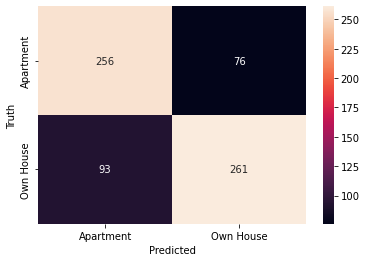

In [45]:
from sklearn.linear_model import LogisticRegression
lr =  LogisticRegression().fit(X_train, y_train)
lr_accuracy,lr_pred = model_performance(lr)

The accuracy of KNeighborsClassifier() is 70.41 %

              precision    recall  f1-score   support

           0       0.68      0.73      0.71       332
           1       0.73      0.68      0.70       354

    accuracy                           0.70       686
   macro avg       0.71      0.70      0.70       686
weighted avg       0.71      0.70      0.70       686

0.7040816326530612


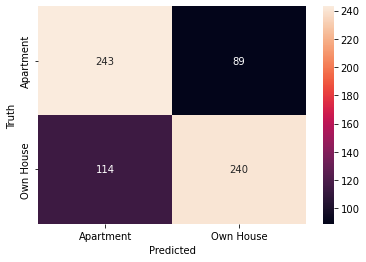

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn =  KNeighborsClassifier().fit(X_train, y_train)
knn_accuracy,knn_pred = model_performance(knn)

The accuracy of DecisionTreeClassifier(max_depth=9) is 76.97 %

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       332
           1       0.78      0.78      0.78       354

    accuracy                           0.77       686
   macro avg       0.77      0.77      0.77       686
weighted avg       0.77      0.77      0.77       686

0.7696793002915452


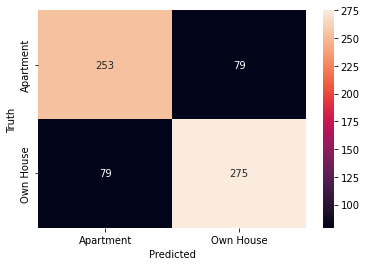

In [195]:
# training a DescisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth = 9).fit(X_train, y_train)
dtree_accuracy,dtree_pred = model_performance(dtree)

## Choosing Random Forest 
* Assumption of no formal distributions. Being a non-parametric model, it can handle skewed and multi-modal data.
* Robust to outliers.
* Works well for non-linear data.
* Low risk of overfitting.
* Runs efficiently on large datasets.

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'max_depth': [4,5,6,7,8,9],'n_estimators': [100,200,500,1000,1200]}
grid_rdf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_rdf.fit(X_train, y_train)
grid_rdf.best_params_

{'max_depth': 9, 'n_estimators': 500}

The accuracy of RandomForestClassifier(max_depth=9, n_estimators=500) is 80.47 %

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       332
           1       0.82      0.80      0.81       354

    accuracy                           0.80       686
   macro avg       0.80      0.80      0.80       686
weighted avg       0.80      0.80      0.80       686

0.8046647230320699


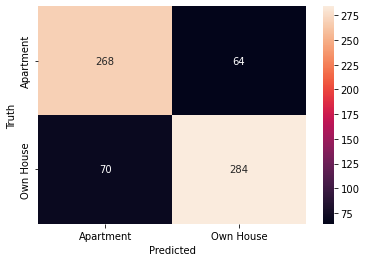

In [49]:
# training a Support Vector Machine classifier
rf = RandomForestClassifier(n_estimators=500,max_depth=9).fit(X_train, y_train)
rf_accuracy,rf_pred = model_performance(rf)

The accuracy of AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=9),
                   learning_rate=0.6, n_estimators=500) is 73.76 %

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       332
           1       0.75      0.73      0.74       354

    accuracy                           0.74       686
   macro avg       0.74      0.74      0.74       686
weighted avg       0.74      0.74      0.74       686

0.7376093294460642


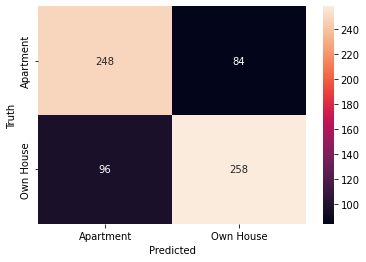

In [50]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
adb = AdaBoostClassifier(DecisionTreeClassifier(max_depth=9), n_estimators=500,algorithm="SAMME.R", learning_rate=.6).fit(X_train,y_train)
adb_linear_accuracy,adb_linear_pred = model_performance(adb)

In [51]:
model_scores_df = pd.DataFrame(zip(model_name,accuracy_list,recall_list,precision_list,f1_score_list,cv_score_list),
                              columns=["Model Name","Accuracy Score","Precision Score","Recall Score","F1 Score","CV Score(5 fold)"])
model_scores_df.set_index('Model Name',inplace=True)
model_scores_df

,Accuracy Score,Precision Score,Recall Score,F1 Score,CV Score(5 fold)
Model Name,,,,,
LogisticRegression(),0.753644,0.737288,0.774481,0.755427,0.742163
KNeighborsClassifier(),0.704082,0.677966,0.729483,0.702782,0.683442
"RandomForestClassifier(max_depth=9, n_estimators=500)",0.804665,0.802260,0.816092,0.809117,0.770613
"AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=9),\n learning_rate=0.6, n_estimators=500)",0.737609,0.728814,0.754386,0.741379,0.699494


# **RANDOMFOREST CLASSIFIER has given a better performance, so choose RANDOMFOREST**



In [57]:
final_model.predict([[4, 100, 5, 5.991464547107982, 4, 1, 0, 0, 0, 0, 0, 0]])

array([1], dtype=int64)

In [52]:
final_model = rf
model_pred = list(final_model.predict(X_test))

In [53]:
pred_df = pd.DataFrame(zip(X_test1["id"],y_test),columns=["ID","True Property Type"])
pred_df["Predicted Property Type"] = model_pred
property_encoder = {"True Property Type":{0:"Apartment",1:"House"},"Predicted Property Type":{0:"Apartment",1:"House"}}
pred_df.replace(property_encoder, inplace=True)
pred_df

,ID,True Property Type,Predicted Property Type
0,140331,House,House
1,6768768,Apartment,Apartment
2,5759668,House,House
3,7635496,House,House
4,2909809,Apartment,Apartment
...,...,...,...
681,4126284,Apartment,House
682,757840,House,House
683,5372156,Apartment,Apartment
684,3529563,House,Apartment


In [55]:
dump(final_model, "property_classification.joblib", compress=0, protocol=None, cache_size=None)

['property_classification.joblib']

In [59]:
from ipywidgets import interact
import ipywidgets as widgets

In [67]:
bath_wid = widgets.RadioButtons(value = 1,
    options=[0,1,2,3,4,5],
    description='Bathrooms',
    disabled=False)

deposit_wid = widgets.FloatSlider(
    value=150,
    min=0,
    max=2500,
    step=0.5,
    description='Maximum Security Deposit (refundable):')

amenities_wid = widgets.IntSlider(value=15,
    min=0,
    max=30,
    step=1,
    description='Maximum amenities:')

budget_wid = widgets.FloatSlider(
    value=175,
    min=20,
    max=1275,
    step=0.5,
    description='Maximum Budget:')

capacity_wid = widgets.IntSlider(value=5,
    min=1,
    max=30,
    step=1,
    description='Maximum Tenants:')

room_wid = widgets.RadioButtons(
    options=['Entire home/apt', 'Private room', 'Shared room'],
    description='Room Type',
    disabled=False)
host_wid = widgets.RadioButtons(
    options=['Label 0','Label 1','Label 2','Label 3','Label 4','Label 5'],
    description='HostType',
    disabled=False)

In [68]:
Room_Type_List = sorted(list(Final_df.room_type.unique()))[1:]
Label_List = sorted(list(Final_df.Label.unique()))[1:]
item = Room_Type_List + Label_List
def reset():
    input_dict = {"bathrooms":0,"security_deposit":0,"Total_Ammenities":0,"Total_Cost":0,"Total_Capacity":0}
    for i in item:
        input_dict[i]=0
    return (input_dict)

In [69]:
def recomender(bathrooms,security_deposit,Total_Ammenities,Total_Cost,Total_Capacity,Room_Type,Host_type):
    input_vector = reset()
    input_vector["bathrooms"]=bathrooms
    input_vector["security_deposit"]=security_deposit
    input_vector["Total_Ammenities"]=Total_Ammenities
    input_vector["Total_Cost"]=np.log(Total_Cost)
    input_vector["Total_Capacity"]=Total_Capacity
    if Room_Type in input_vector:
        input_vector[Room_Type]=1
    if int(Host_type[-1]) in input_vector:   
        input_vector[int(Host_type[-1])]=1
    input_list=list(input_vector.values())
    prediction = rf.predict([input_list])
    if prediction == 1:
        print("Independant_House")
    else:
        print("Apart")
    print(prediction)

In [70]:
interact(recomender, 
         bathrooms=bath_wid,security_deposit=deposit_wid,Total_Ammenities=amenities_wid,Total_Cost=budget_wid,
         Total_Capacity=capacity_wid,Room_Type=room_wid,Host_type=host_wid);

interactive(children=(RadioButtons(description='Bathrooms', index=1, options=(0, 1, 2, 3, 4, 5), value=1), Flo…